In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D,Flatten, Dense, Dropout, BatchNormalization, Input,RandomRotation,RandomFlip,RandomContrast
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
import os
import cv2
from pyswarm import pso

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [ ]:
bengin_path ='/content/drive/MyDrive/Colab Notebooks/Deep Learning/Lung cancer dataset/Bengin cases'
malignant_path='/content/drive/MyDrive/Colab Notebooks/Deep Learning/Lung cancer dataset/Malignant cases'
normal_path='/content/drive/MyDrive/Colab Notebooks/Deep Learning/Lung cancer dataset/Normal cases'
img_classes = ["Bengin cases", "Malignant cases", "Normal cases"]
path_list = [bengin_path, malignant_path, normal_path]

img_path = []
class_labels = []
for i, dir_list in enumerate(path_list):
    name_img = os.listdir(dir_list)
    for name_file in name_img:
        img = os.path.join(dir_list,name_file)
        img_path.append(img)
        class_labels.append(img_classes[i])

data = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

data.head()

img_path         label
0  /content/drive/MyDrive/Colab Notebooks/Deep Le...  Bengin cases
1  /content/drive/MyDrive/Colab Notebooks/Deep Le...  Bengin cases
2  /content/drive/MyDrive/Colab Notebooks/Deep Le...  Bengin cases
3  /content/drive/MyDrive/Colab Notebooks/Deep Le...  Bengin cases
4  /content/drive/MyDrive/Colab Notebooks/Deep Le...  Bengin cases

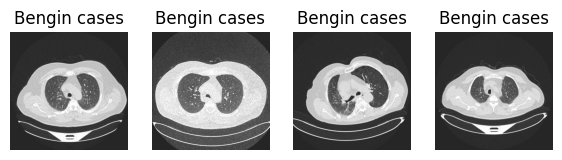

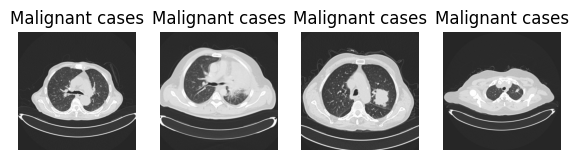

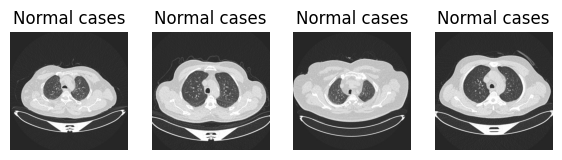

In [ ]:
for category, group in data.groupby("label"):
    fig, ax = plt.subplots(1,4, figsize = (7,7))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(4).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

In [ ]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(data, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")

Train shape = (767, 2)
Test shape = (165, 2)
Validation shape = (165, 2)


In [ ]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

# Data Augementation and Loading

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
                                  preprocessing_function = preprocessing_denoise,
                                  rotation_range = 30,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.2,
                                  shear_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

train_dataset = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

val_dataset = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

test_dataset = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


In [ ]:
train_dataset

In [ ]:
val_dataset

In [ ]:
classes = list(train_dataset.class_indices.keys())
classes

['Bengin cases', 'Malignant cases', 'Normal cases']

In [ ]:
#Weight Class
class_weights = class_weight.compute_class_weight(
           class_weight = 'balanced',
            classes = np.unique(train_dataset.classes),
            y = train_dataset.classes)

train_class_weights = dict(enumerate(class_weights))

for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Bengin cases : 3.1958333333333333
Malignant cases : 0.6606373815676141
Normal cases : 0.8522222222222222


# CNN Model

In [ ]:
model= Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), input_shape = (256, 256, 3), activation = "relu", padding = "same"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(4096, activation = "relu"),
    Dropout(0.5),
    Dense(256),
    Dropout(0.25),
    Dense(3, activation = "softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                        

In [ ]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ["accuracy"],
)

In [ ]:
epochs = 50
history = model.fit(train_dataset,
                   steps_per_epoch = len(train_dataset),
                   batch_size = 32,
                   validation_data = val_dataset,
                   validation_steps = len(val_dataset),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 17s 726ms/step - loss: 0.4695 - accuracy: 0.7901 - val_loss: 3.6600 - val_accuracy: 0.3697 - lr: 5.0000e-04
Epoch 2/50
24/24 [==============================] - 19s 785ms/step - loss: 0.5364 - accuracy: 0.8031 - val_loss: 2.1183 - val_accuracy: 0.2970 - lr: 5.0000e-04
Epoch 3/50
24/24 [==============================] - 17s 717ms/step - loss: 0.5033 - accuracy: 0.7797 - val_loss: 0.8339 - val_accuracy: 0.6909 - lr: 5.0000e-04
Epoch 4/50
24/24 [==============================] - 17s 720ms/step - loss: 0.5202 - accuracy: 0.8096 - val_loss: 0.6408 - val_accuracy: 0.6970 - lr: 5.0000e-04
Epoch 5/50
24/24 [==============================] - 17s 715ms/step - loss: 0.4724 - accuracy: 0.7927 - val_loss: 2.5141 - val_accuracy: 0.7636 - lr: 5.0000e-04
Epoch 6/50
24/24 [==============================] - 18s 769ms/step - loss: 0.4834 - accuracy: 0.8083 - val_loss: 29.4602 - val_accuracy: 0.5273 - lr: 5.0000e-04
Epoch 7/50
24/24 [=====================

# Evaluation

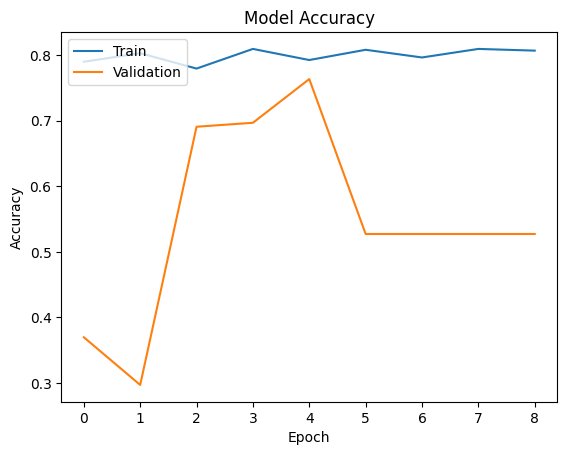

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

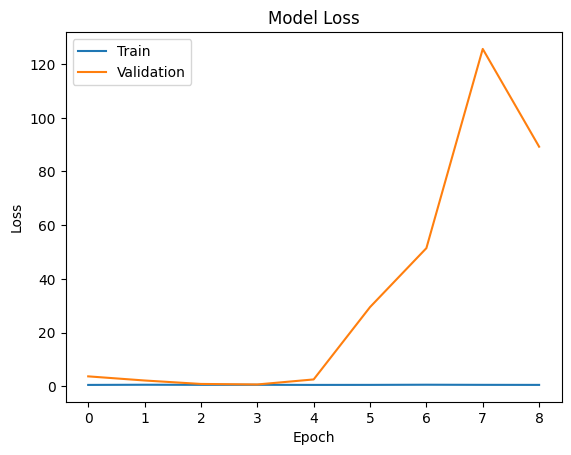

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def evaluate_model(model, test_generator):
    #Calculate test loss and accuracy
    results = model.evaluate(test_dataset, verbose = 0)
    print(f"Test Loss = {results[0]}")
    print(f"Test Accuracy = {results[1]}")

In [ ]:
evaluate_model(model, test_dataset)

Test Loss = 0.458316832780838
Test Accuracy = 0.8121212124824524


In [ ]:
def history_plot(epochs, history):
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["accuracy"], name = "Training Accuracy"))
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_accuracy"], name = "Validation Accuracy"))
    fig1.update_layout(title = "Training and Validation Accuracy", xaxis_title = "Epoch", yaxis_title = "Accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["loss"], name = "Training Loss"))
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_loss"], name = "Validation Loss"))
    fig2.update_layout(title = "Training and Validation Loss", xaxis_title = "Epoch", yaxis_title = "Loss")
    fig2.show()

In [ ]:
history_plot(epochs, history)

# Testing

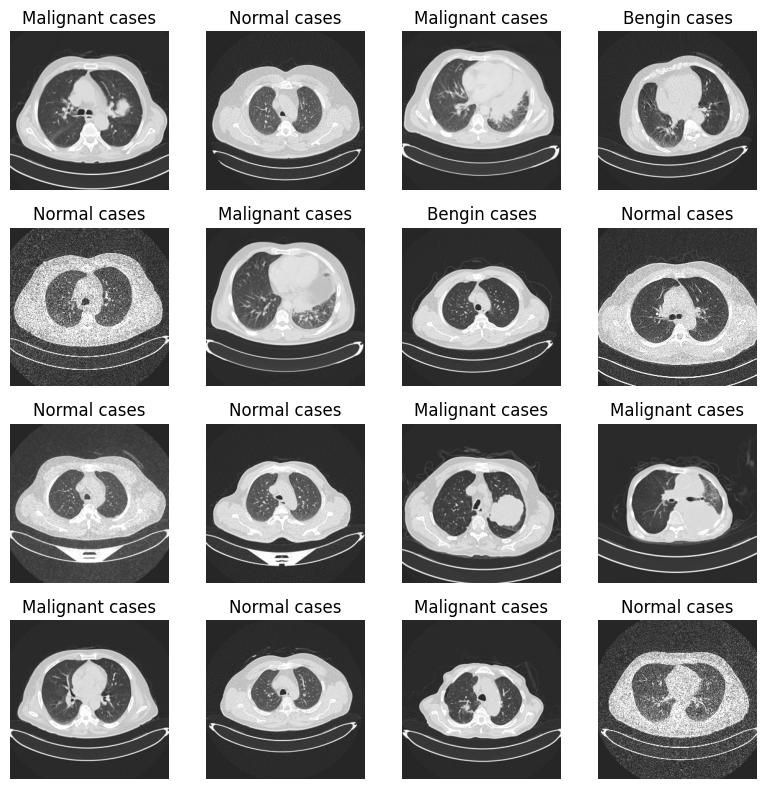

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
CONFIGURATION = {
    "IM_SIZE": 256,
    "CLASS_NAMES": ["Bengin cases", "Malignant cases", "Normal cases"],
}
images, labels = next(iter(test_dataset))
labels = np.argmax(labels, axis=1)
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i])
    ax.set_title(CONFIGURATION['CLASS_NAMES'][labels[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
CONFIGURATION = {
    "IM_SIZE": 256,
    "CLASS_NAMES": ["Begin cases", "Malignat cases", "Normal cases"],
}
batch=next(test_dataset)
test_images,true_labels = batch
random_index = np.random.randint(len(test_images))
test_image = test_images[random_index]
true_label_index = tf.argmax(true_labels[random_index])

test_image = tf.image.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
im = tf.expand_dims(test_image, axis=0)
predicted_label_index = tf.argmax(model(im), axis=-1)
print("True Label:", CONFIGURATION["CLASS_NAMES"][true_label_index.numpy()])
print("Predicted Label:", CONFIGURATION["CLASS_NAMES"][predicted_label_index[0]])



True Label: Malignat cases
Predicted Label: Malignat cases


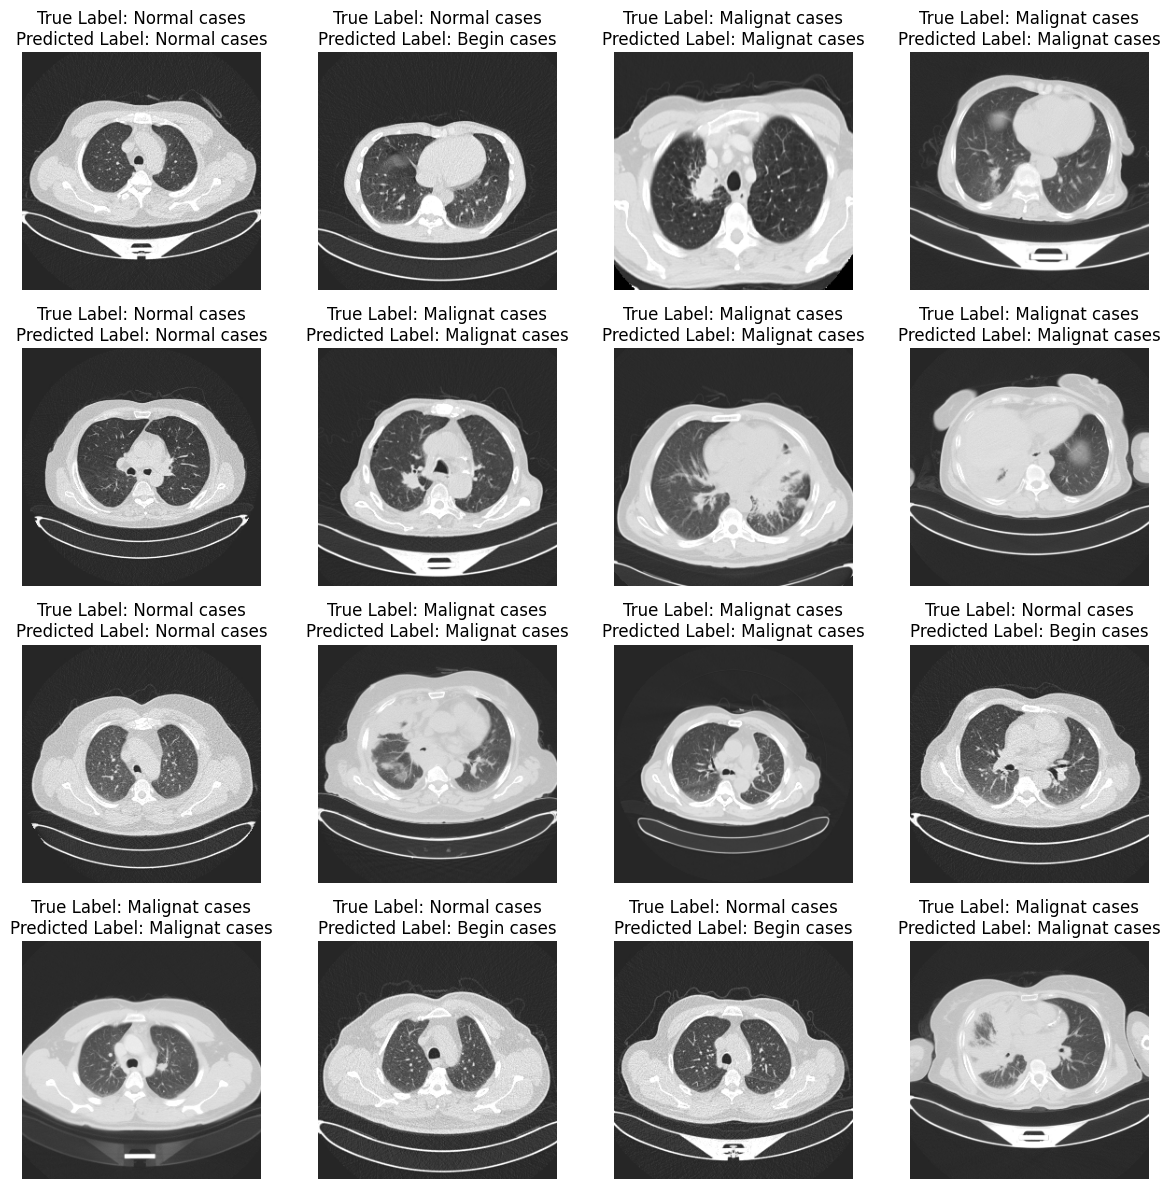

In [ ]:
images, labels = next(iter(test_dataset))
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i])
    true_label_index = np.argmax(labels[i])  # Get the index of the true label for the ith image
    true_label = CONFIGURATION["CLASS_NAMES"][true_label_index]  # Get the true label name from the configuration
    predicted_label_index = np.argmax(model(tf.expand_dims(images[i], axis=0)))  # Get the index of the predicted label for the ith image
    predicted_label = CONFIGURATION["CLASS_NAMES"][predicted_label_index]  # Get the predicted label name from the configuration
    ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
model.save("CNN.keras")

# Resnet

In [ ]:
resnet_base_model=tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(256,256,3)
)

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
for layer in resnet_base_model.layers:
    layer.trainable = False

In [ ]:
resnet_model = Sequential()
resnet_model.add(Input(shape = (256, 256, 3)))
resnet_model.add(resnet_base_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024, activation = "relu"))
# resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(3, activation = "softmax"))

print(resnet_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_5 (Dense)             (None, 1024)              134218752 
                                                                 
 dense_6 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 157809539 (602.00 MB)
Trainable params: 134221827 (512.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
None


In [ ]:
resnet_model.compile(optimizer = Adam(0.0001),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [ ]:
epochs = 50
history = resnet_model.fit(train_dataset,
                   steps_per_epoch = len(train_dataset),
                   batch_size = 32,
                   validation_data = val_dataset,
                   validation_steps = len(val_dataset),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 28s 1s/step - loss: 4.5555 - accuracy: 0.3833 - val_loss: 1.5014 - val_accuracy: 0.3273 - lr: 1.0000e-04
Epoch 2/50
24/24 [==============================] - 20s 826ms/step - loss: 1.4039 - accuracy: 0.4420 - val_loss: 1.1324 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 3/50
24/24 [==============================] - 18s 746ms/step - loss: 1.2210 - accuracy: 0.4720 - val_loss: 1.9900 - val_accuracy: 0.4606 - lr: 1.0000e-04
Epoch 4/50
24/24 [==============================] - 19s 787ms/step - loss: 1.1569 - accuracy: 0.4863 - val_loss: 1.4306 - val_accuracy: 0.4788 - lr: 1.0000e-04
Epoch 5/50
24/24 [==============================] - 18s 747ms/step - loss: 1.3827 - accuracy: 0.5020 - val_loss: 1.4743 - val_accuracy: 0.3091 - lr: 2.0000e-05
Epoch 6/50
24/24 [==============================] - 21s 859ms/step - loss: 0.9686 - accuracy: 0.5450 - val_loss: 0.9475 - val_accuracy: 0.5152 - lr: 2.0000e-05
Epoch 7/50
24/24 [=========================

In [ ]:
history_plot(epochs, history)

In [ ]:
evaluate_model(resnet_model, test_dataset)

Test Loss = 0.8625239729881287
Test Accuracy = 0.521212100982666


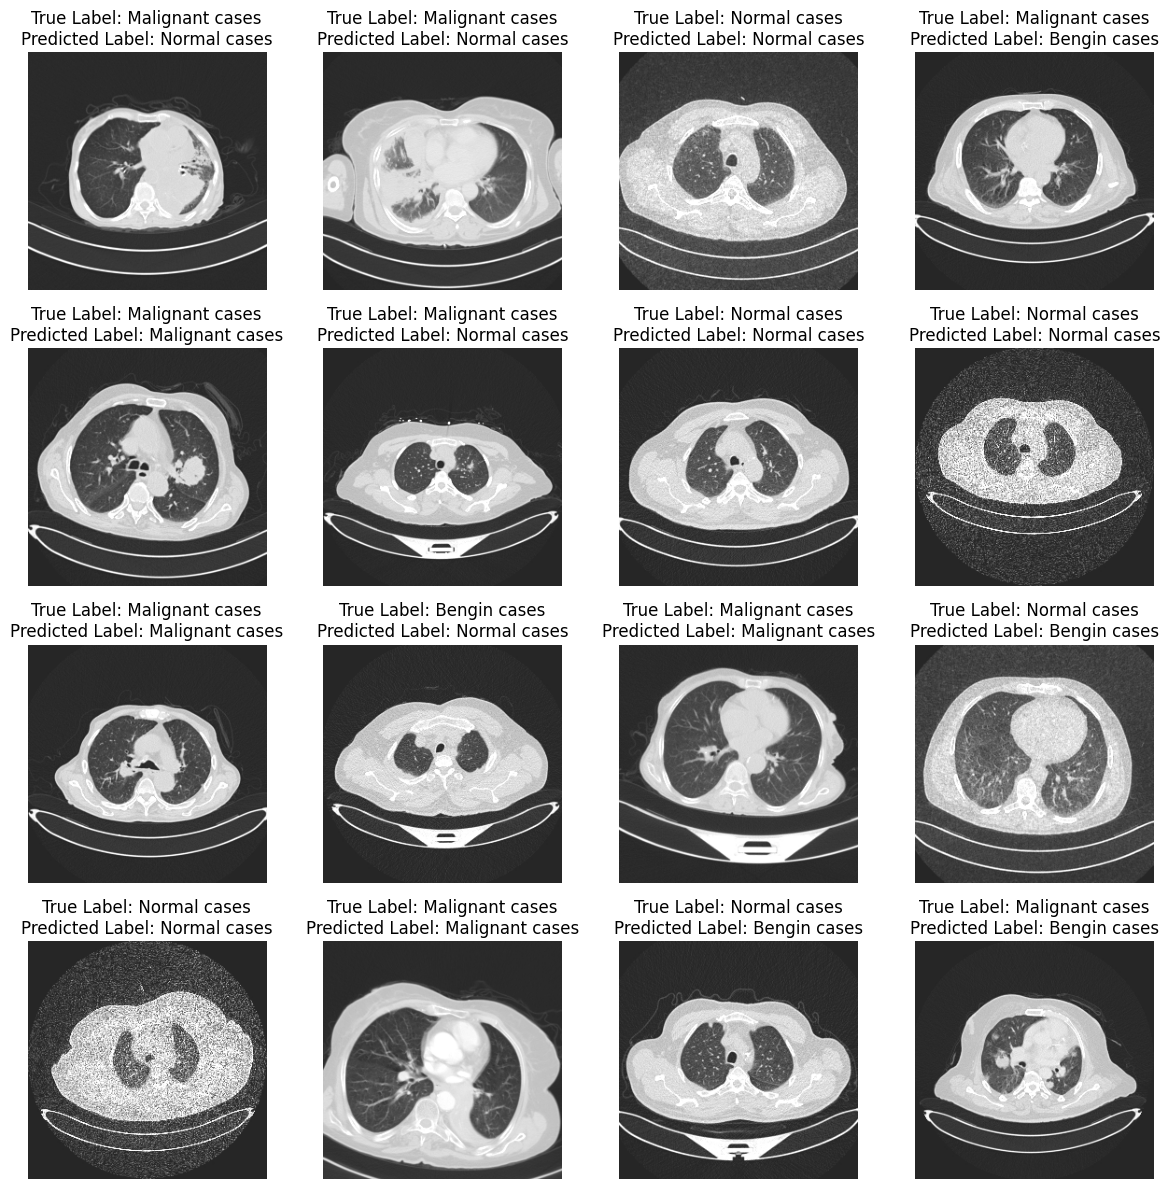

In [ ]:
images, labels = next(iter(test_dataset))
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i])
    true_label_index = np.argmax(labels[i])  # Get the index of the true label for the ith image
    true_label = CONFIGURATION["CLASS_NAMES"][true_label_index]  # Get the true label name from the configuration
    predicted_label_index = np.argmax(resnet_model(tf.expand_dims(images[i], axis=0)))  # Get the index of the predicted label for the ith image
    predicted_label = CONFIGURATION["CLASS_NAMES"][predicted_label_index]  # Get the predicted label name from the configuration
    ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Pretrained Model InceptionV3

In [ ]:
incep_base_model = InceptionV3(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")


87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in incep_base_model.layers:
    layer.trainable = False
# fasle -> each layer in the pre-trained model means that the weights of these layers will not be updated during training.
# By freezing the weights of the pre-trained layers, we prevent them from being modified or updated while training the model further.

In [ ]:
incep_model= Sequential()
incep_model.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
incep_model.add(incep_base_model)
incep_model.add(Flatten())
incep_model.add(Dense(1024, activation = "relu"))
incep_model.add(Dropout(0.4))
incep_model.add(Dense(3, activation = "softmax"))

print(incep_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              75498496  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 97304355 (371.19 MB)
Trainable params: 75501571 (288.02 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
None

In [ ]:
epochs = 50
incep_model.compile(optimizer = Adam(0.0005),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [ ]:
history = incep_model.fit(train_dataset,
                   steps_per_epoch = len(train_dataset),
                   batch_size = 64,
                   validation_data = val_dataset,
                   validation_steps = len(val_dataset),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 31s 956ms/step - loss: 26.6806 - accuracy: 0.5332 - val_loss: 1.4502 - val_accuracy: 0.7818 - lr: 5.0000e-04
Epoch 2/50
24/24 [==============================] - 20s 847ms/step - loss: 3.0232 - accuracy: 0.7158 - val_loss: 0.6433 - val_accuracy: 0.8182 - lr: 5.0000e-04
Epoch 3/50
24/24 [==============================] - 19s 800ms/step - loss: 1.2604 - accuracy: 0.7249 - val_loss: 0.3447 - val_accuracy: 0.8667 - lr: 5.0000e-04
Epoch 4/50
24/24 [==============================] - 20s 835ms/step - loss: 0.6793 - accuracy: 0.7823 - val_loss: 0.3298 - val_accuracy: 0.8848 - lr: 5.0000e-04
Epoch 5/50
24/24 [==============================] - 18s 770ms/step - loss: 0.5735 - accuracy: 0.7640 - val_loss: 0.4137 - val_accuracy: 0.8182 - lr: 5.0000e-04
Epoch 6/50
24/24 [==============================] - 20s 818ms/step - loss: 0.5884 - accuracy: 0.7510 - val_loss: 0.3459 - val_accuracy: 0.8667 - lr: 5.0000e-04
Epoch 7/50
24/24 [=====================

# Incep-Evaluate

In [ ]:
history_plot(epochs, history)

In [ ]:
evaluate_model(incep_model, test_dataset)

Test Loss = 0.32838353514671326
Test Accuracy = 0.842424213886261


In [ ]:
CONFIGURATION = {
    "IM_SIZE": 256,
    "CLASS_NAMES": ["Begin cases", "Malignat cases", "Normal cases"],
}
batch=next(test_dataset)
test_images,true_labels = batch
random_index = np.random.randint(len(test_images))
test_image = test_images[random_index]
true_label_index = tf.argmax(true_labels[random_index])

test_image = tf.image.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
im = tf.expand_dims(test_image, axis=0)
predicted_label_index = tf.argmax(incep_model(im), axis=-1)
print("True Label:", CONFIGURATION["CLASS_NAMES"][true_label_index.numpy()])
print("Predicted Label:", CONFIGURATION["CLASS_NAMES"][predicted_label_index[0]])


In [ ]:
images, labels = next(iter(test_dataset))
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i])
    true_label_index = np.argmax(labels[i])  # Get the index of the true label for the ith image
    true_label = CONFIGURATION["CLASS_NAMES"][true_label_index]  # Get the true label name from the configuration
    predicted_label_index = np.argmax(incep_model(tf.expand_dims(images[i], axis=0)))  # Get the index of the predicted label for the ith image
    predicted_label = CONFIGURATION["CLASS_NAMES"][predicted_label_index]  # Get the predicted label name from the configuration
    ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Fine Tunig Inception V3

In [ ]:
incep_base_model.trainable = True

for l in incep_base_model.layers[:10]:
    print(l.name, l.trainable)

incep_model.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

print(incep_model.summary())

input_1 True
conv2d_6 True
batch_normalization_6 True
activation True
conv2d_7 True
batch_normalization_7 True
activation_1 True
conv2d_8 True
batch_normalization_8 True
activation_2 True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              75498496  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 3075      
                                                                

In [ ]:
epochs = 50
history = incep_model.fit(train_dataset,
                   steps_per_epoch = len(train_dataset),
                   batch_size = 64,
                   validation_data = val_dataset,
                   validation_steps = len(val_dataset),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 64s 969ms/step - loss: 1.8070 - accuracy: 0.6975 - val_loss: 0.6119 - val_accuracy: 0.7879 - lr: 1.0000e-05
Epoch 2/50
24/24 [==============================] - 22s 901ms/step - loss: 0.8123 - accuracy: 0.7653 - val_loss: 0.5077 - val_accuracy: 0.8121 - lr: 1.0000e-05
Epoch 3/50
24/24 [==============================] - 20s 840ms/step - loss: 0.6488 - accuracy: 0.7849 - val_loss: 0.3317 - val_accuracy: 0.8848 - lr: 1.0000e-05
Epoch 4/50
24/24 [==============================] - 22s 900ms/step - loss: 0.6079 - accuracy: 0.7705 - val_loss: 0.3243 - val_accuracy: 0.8667 - lr: 1.0000e-05
Epoch 5/50
24/24 [==============================] - 22s 896ms/step - loss: 0.5960 - accuracy: 0.7731 - val_loss: 0.3464 - val_accuracy: 0.8727 - lr: 1.0000e-05
Epoch 6/50
24/24 [==============================] - 20s 822ms/step - loss: 0.5536 - accuracy: 0.7679 - val_loss: 0.3628 - val_accuracy: 0.8485 - lr: 1.0000e-05
Epoch 7/50
24/24 [======================

In [ ]:
history_plot(epochs, history)

In [ ]:
evaluate_model(incep_model, test_dataset)

Test Loss = 0.4256480038166046
Test Accuracy = 0.8606060743331909


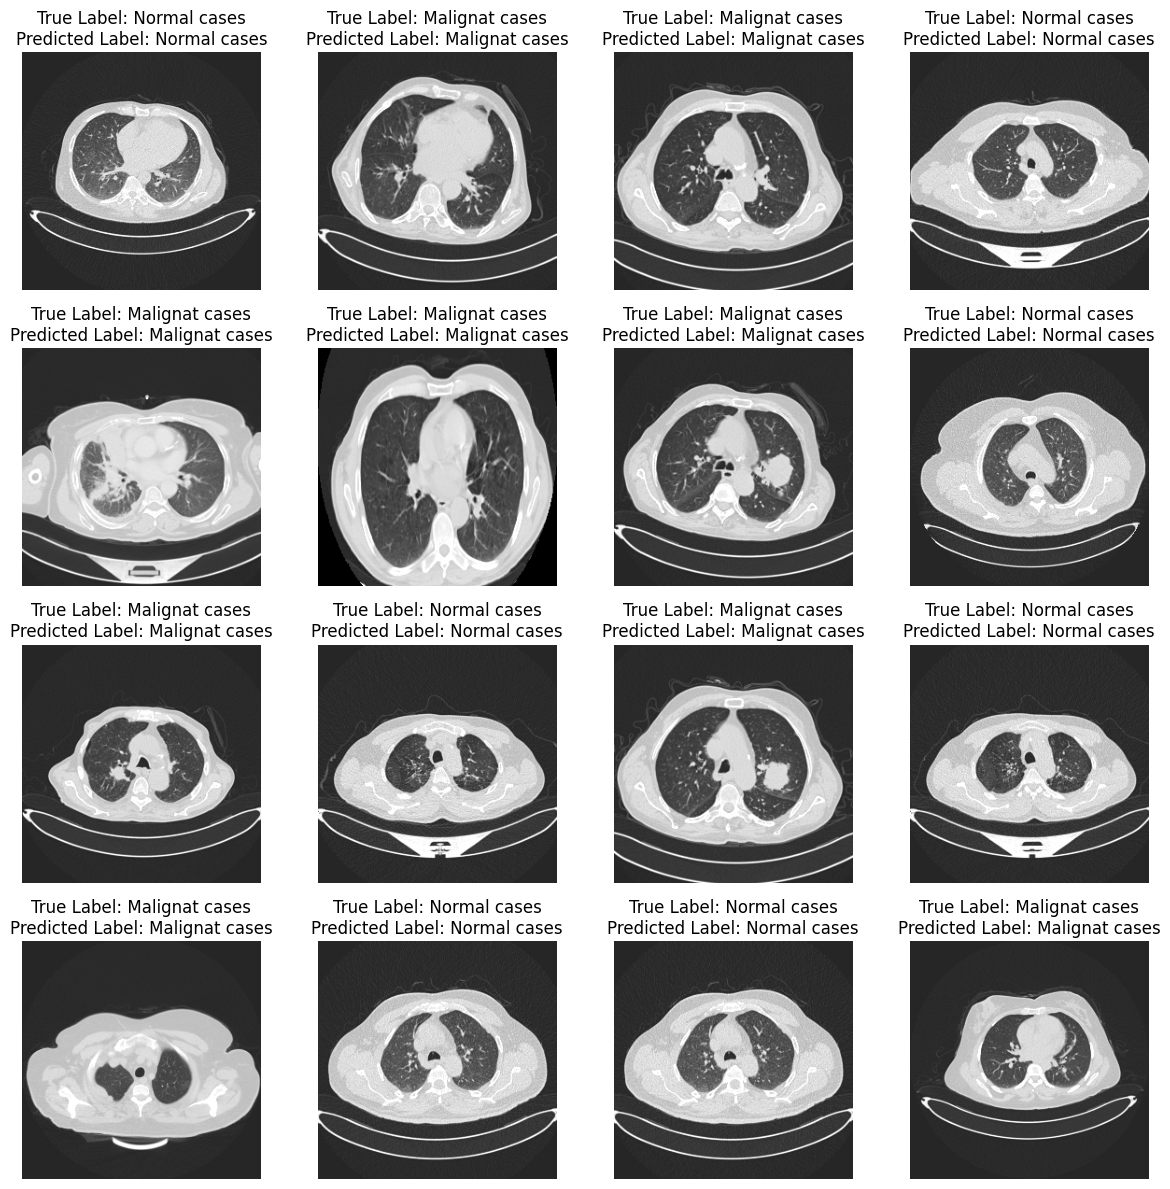

In [ ]:
images, labels = next(iter(test_dataset))
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i])
    true_label_index = np.argmax(labels[i])  # Get the index of the true label for the ith image
    true_label = CONFIGURATION["CLASS_NAMES"][true_label_index]  # Get the true label name from the configuration
    predicted_label_index = np.argmax(incep_model(tf.expand_dims(images[i], axis=0)))  # Get the index of the predicted label for the ith image
    predicted_label = CONFIGURATION["CLASS_NAMES"][predicted_label_index]  # Get the predicted label name from the configuration
    ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
incep_model.save("InceptionV3.keras")

# VGG-16

In [ ]:
vgg16_base_model = VGG16(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg16_base_model.layers:
    layer.trainable = False

In [ ]:
vgg16_model = Sequential()
vgg16_model.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
vgg16_model.add(vgg16_base_model)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(1024, activation = "relu"))
vgg16_model.add(Dropout(0.4))
vgg16_model.add(Dense(3, activation = "softmax"))

print(vgg16_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              33555456  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 48273219 (184.15 MB)
Trainable params: 33558531 (128.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
None

In [ ]:
vgg16_model.compile(optimizer = Adam(0.0005),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])


In [ ]:
epochs = 50
history = vgg16_model.fit(train_dataset,
                   steps_per_epoch = len(train_dataset),
                   batch_size = 64,
                   validation_data = val_dataset,
                   validation_steps = len(val_dataset),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 34s 1s/step - loss: 3.1224 - accuracy: 0.4785 - val_loss: 0.4469 - val_accuracy: 0.7879 - lr: 5.0000e-04
Epoch 2/50
24/24 [==============================] - 19s 783ms/step - loss: 1.3971 - accuracy: 0.6349 - val_loss: 0.4520 - val_accuracy: 0.7818 - lr: 5.0000e-04
Epoch 3/50
24/24 [==============================] - 20s 815ms/step - loss: 0.8190 - accuracy: 0.6754 - val_loss: 0.7322 - val_accuracy: 0.6485 - lr: 5.0000e-04
Epoch 4/50
24/24 [==============================] - 19s 782ms/step - loss: 0.7153 - accuracy: 0.7379 - val_loss: 0.7836 - val_accuracy: 0.6182 - lr: 1.0000e-04
Epoch 5/50
24/24 [==============================] - 20s 834ms/step - loss: 0.6342 - accuracy: 0.7366 - val_loss: 0.4505 - val_accuracy: 0.7394 - lr: 1.0000e-04
Epoch 6/50
24/24 [==============================] - 19s 810ms/step - loss: 0.5813 - accuracy: 0.7223 - val_loss: 0.3519 - val_accuracy: 0.8303 - lr: 2.0000e-05
Epoch 7/50
24/24 [=========================

In [ ]:
history_plot(epochs, history)

In [ ]:
evaluate_model(vgg16_model,test_dataset)

Test Loss = 0.30530431866645813
Test Accuracy = 0.903030276298523


# Fine Tuning VGG16

In [ ]:
vgg16_base_model.trainable = True

for l in vgg16_base_model.layers[:10]:
    print(l.name, l.trainable)

vgg16_model.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

print(vgg16_model.summary())

input_3 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              33555456  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 3)                 3075      
                                                                 
Total params:

In [ ]:
epochs = 50
history = vgg16_model.fit(train_dataset,
                   steps_per_epoch = len(train_dataset),
                   batch_size = 64,
                   validation_data = val_dataset,
                   validation_steps = len(val_dataset),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                              ],
                   epochs = epochs)

Epoch 1/50
24/24 [==============================] - 51s 1s/step - loss: 0.5242 - accuracy: 0.7771 - val_loss: 0.2764 - val_accuracy: 0.8970 - lr: 1.0000e-05
Epoch 2/50
24/24 [==============================] - 23s 952ms/step - loss: 0.4737 - accuracy: 0.8083 - val_loss: 0.2511 - val_accuracy: 0.9212 - lr: 1.0000e-05
Epoch 3/50
24/24 [==============================] - 23s 929ms/step - loss: 0.4375 - accuracy: 0.8253 - val_loss: 0.2190 - val_accuracy: 0.9212 - lr: 1.0000e-05
Epoch 4/50
24/24 [==============================] - 24s 973ms/step - loss: 0.3941 - accuracy: 0.8618 - val_loss: 0.1873 - val_accuracy: 0.9273 - lr: 1.0000e-05
Epoch 5/50
24/24 [==============================] - 23s 954ms/step - loss: 0.3482 - accuracy: 0.8801 - val_loss: 0.1548 - val_accuracy: 0.9212 - lr: 1.0000e-05
Epoch 6/50
 2/24 [=>............................] - ETA: 21s - loss: 0.3757 - accuracy: 0.9048

In [ ]:
history_plot(epochs, history)

In [ ]:
evaluate_model(vgg16_model, test_dataset)

Test Loss = 0.20485250651836395
Test Accuracy = 0.9090909361839294


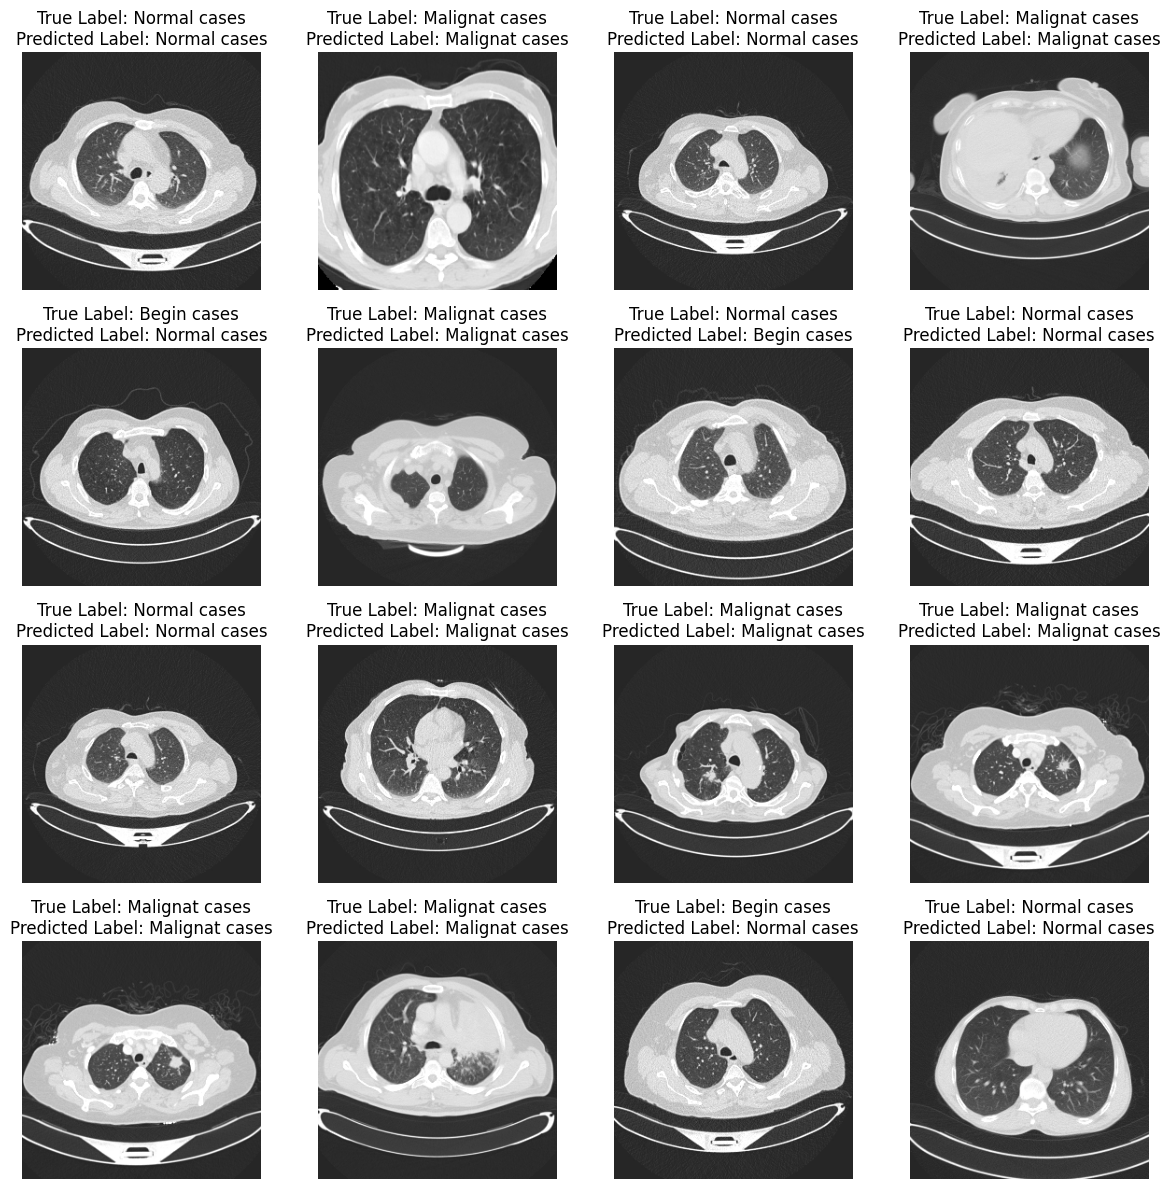

In [ ]:
images, labels = next(iter(test_dataset))
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(images[i])
    true_label_index = np.argmax(labels[i])  # Get the index of the true label for the ith image
    true_label = CONFIGURATION["CLASS_NAMES"][true_label_index]  # Get the true label name from the configuration
    predicted_label_index = np.argmax(vgg16_model(tf.expand_dims(images[i], axis=0)))  # Get the index of the predicted label for the ith image
    predicted_label = CONFIGURATION["CLASS_NAMES"][predicted_label_index]  # Get the predicted label name from the configuration
    ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
vgg16_model.save("VGG16.keras")